# Aligning partial coronal brain sections with the Allen Brain Altas

In this notebook, we align a STARmap dataset of a the right hemisphere of a mouse brain to the Allen Brain Atlas.



We will use STalign to achieve this alignment. We will first load the relevant code libraries.

In [1]:
#Import dependencies

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
#from STalign import STalign
import copy
import pandas as pd

In [2]:
import sys
sys.path.append("../../STalign")
import STalign

We have already downloaded STARmap datasets and stored them in a folder called starmap_data.


Now, we can read in the cell infomation using pandas as pd.

We must load all cell x and y positions into the variable x and y respectively. Importantly, the *scale* of the loaded data must approximately match the Allen Brain Atlas, where ~1 pixel unit is ~1 um

In [3]:
target_file = r"C:\Users\Manjari\Downloads\1000geneset0.5nmfulldapiimage_crop.tif"
atlas_file = r"C:\Users\Manjari\Downloads\ext-d000024_3Drecon-ADMBA-E13pt5_pub\3Drecon-ADMBA-E13pt5_atlasVolume.mhd"
annotation_file = r"C:\Users\Manjari\Downloads\ext-d000024_3Drecon-ADMBA-E13pt5_pub\3Drecon-ADMBA-E13pt5_annotation.mhd"


In [4]:
import SimpleITK as sitk
import numpy as np
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, origin and spacing of the image.
'''

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

In [5]:
#Load file
from PIL import Image

target = np.array(Image.open(target_file))
atlas,l,l = load_itk(atlas_file)
annotation,l,l = load_itk(annotation_file)

X_ = np.arange(0,len(target[0,:]))
Y_ = np.arange(0,len(target[:,0]))

In [6]:
W = target
atlas = atlas.transpose(2,0,1)[:,:,0:250]

In [7]:
annotation = annotation.transpose(2,0,1)[:,:,0:250]

In [8]:
W.shape

(831, 1000)

We can visualize the resulting rasterized image.

<IPython.core.display.Javascript object>


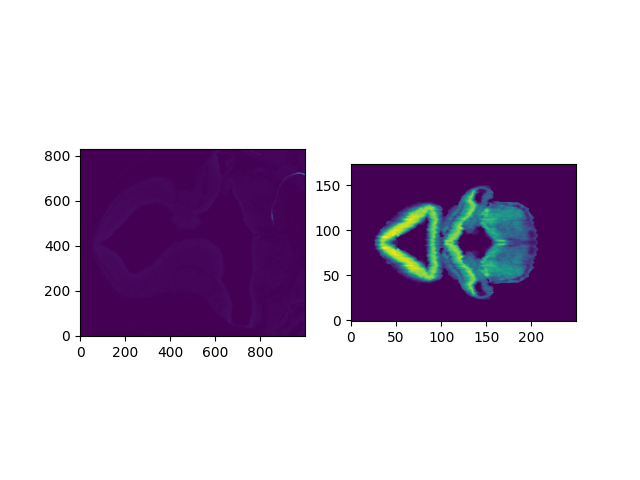

In [9]:
#Plot unrasterized/rasterized images
fig,ax = plt.subplots(1,2)
ax[0].imshow(W,  origin='lower') 


ax[1].imshow(atlas[280],  origin='lower')    



Now we need to find an approximate slice number in the Allen Atlas to initialize the alignment. Evaluate whether the value of slice is similar to the target image by viewing a side by side comparison of the ABA slice and the target image. If not, change the value of slice. In this example, slice = 0 is anterior and slice = 264 is posterior.

<IPython.core.display.Javascript object>


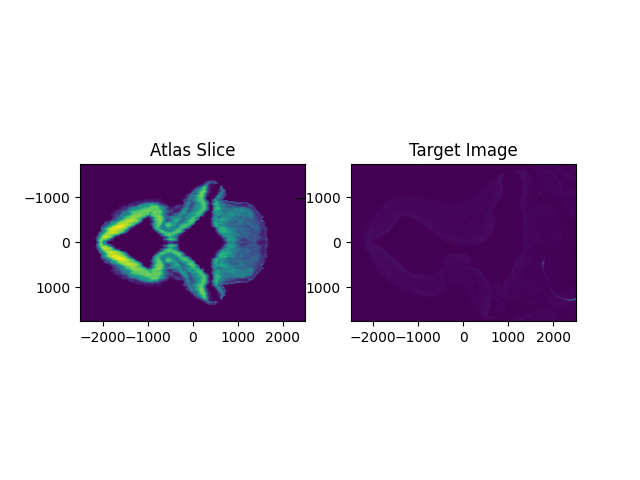

In [10]:
#find slice
#peruse through images in atlas
# Loading the atlas
slice = 265

A = atlas  
L = annotation

dxA = np.diag([[20,0,0],[0,20,0],[0,0,20]])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(A[slice],extent=extentA)
ax[0].set_title('Atlas Slice')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()    


In [11]:
Image.fromarray(A[265]).save('atlasimg.tiff')

In [12]:
len(xA[2])

250

Next, we need to find an approximate rotation angle of the Allen Atlas to initialize the alignment. Evaluate whether the rotation of the atlas is similar to the target image by viewing a side by side comparison of the ABA slice and the target image. If not, change the value of theta_deg. Note: the rotation here is defined in degrees.

<IPython.core.display.Javascript object>


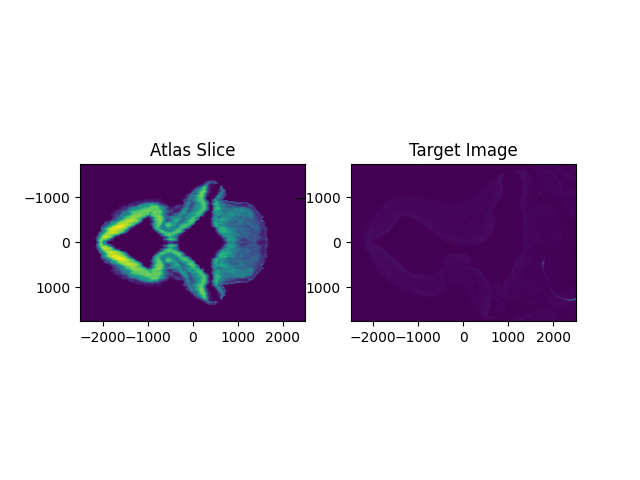

In [13]:
from scipy.ndimage import rotate

theta_deg = 0

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
ax[0].set_title('Atlas Slice')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()    


Next, specify if there are any points on the image above that can be approximately matched with eachother and add them in the following format. This helps speed up alignment. (OPTIONAL)


In [14]:
points_atlas = np.array([[0,0]]) #(-y,-x)
points_target = np.array([[-3700,0]]) # (-y,-x)
Li,Ti = STalign.L_T_from_points(points_atlas,points_target)

We can define atlas and target points, xI and xJ, as well as atlas and target images, I and J. 

In [15]:
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))
Inorm = STalign.normalize(I, t_min=0, t_max=1)
Jnorm = STalign.normalize(J, t_min=0, t_max=1)

Now that we can chosen the slice number and rotation angle, we are ready to initialize parameters related to our alignment. 

In [16]:
sigmaA = 0.5 #standard deviation of artifact intensities
sigmaB = 0.5 #standard deviation of background intensities
sigmaM = 3 #standard deviation of matching tissue intenities
muA = torch.tensor([5,5,5],device='cpu') #average of artifact intensities
muB = torch.tensor([0.5,0.5,0.5],device='cpu') #average of background intensities


We can change the parameters above by looking at the intensity histogram of our target image (below). We need to consider intensities of artifacts (tissue that is present in the target image and absent in the atlas), which is usually in the upper range of intensity values. We also need to find the intensity of the background values that does not correspond to any tissue, usually around 0, and standard deviations for these values. The matching tissue intensities are regions that should have tissue that can be aligned in both the atlas and the target image.

In [17]:
J = np.clip(J, 0,5)

<IPython.core.display.Javascript object>


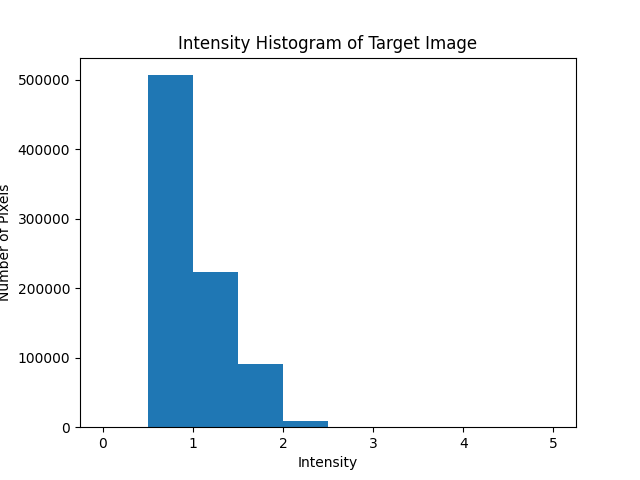

Text(0.5, 1.0, 'Intensity Histogram of Target Image')

In [18]:
fig,ax = plt.subplots()
ax.hist(J.ravel(), range=(0,5))
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

The following parameters vary depending on your target image and the duration & accuracy of the alignment. The scale parameters refer to a scaling of the atlas in (x, y, z) to match the size of the target image. The nt parameter ensures smoothness and invertibility of the image transformation. The niter refers to the number of iteration steps in gradient descent to achieve minimum error between the altas and the target image.

In [19]:
# initialize variables
scale_x = 0.25 #default = 0.9
scale_y = 0.25 #default = 0.9
scale_z = 0.9 #default = 0.9
theta0 = (np.pi/180)*theta_deg

# get an initial guess
#if 'Ti' in locals():
#    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
#else:
#    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])
T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])


scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas)#np.identity(3)

Now, we can perform alignment of the atlas to our target slice.

<IPython.core.display.Javascript object>


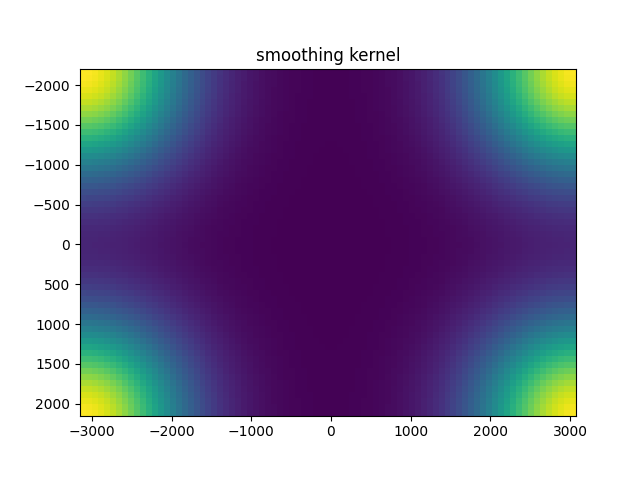

<IPython.core.display.Javascript object>


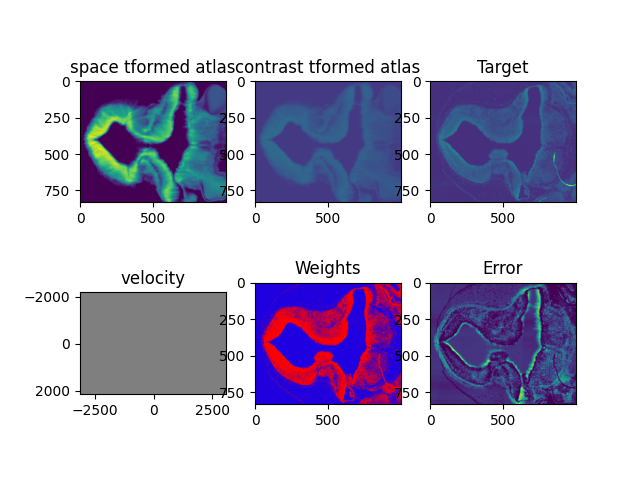

<IPython.core.display.Javascript object>


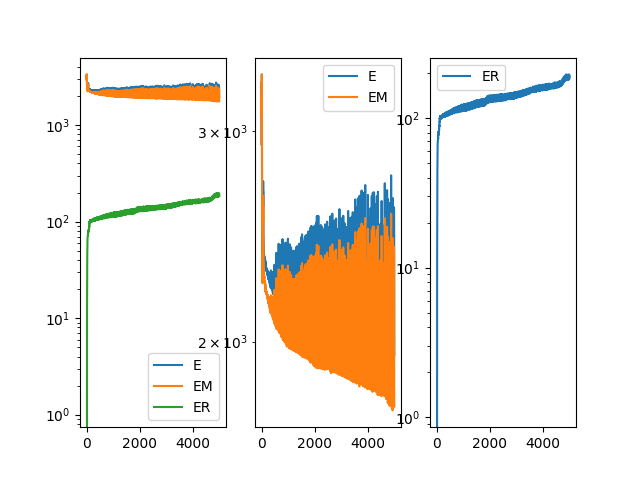

CPU times: total: 2d 3h 50min 13s
Wall time: 2h 56min 32s


In [21]:
%%time
#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=5000,
    a=150,
    epV = 1e5,
    sigmaP = 2e-1,
    device='cpu',
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    muA = muA, #average of artifact intensities
    muB = muB, #average of background intensities
    diffeo_start=10
)


In [22]:
A = transform['A']
v = transform['v']
xv = transform['xv']
Xs = transform['Xs']

Once we have aligned the atlas to our target image, we can project the brain regions defined in the atlas to our target image and export these annotations, along with information about the positions of the atlas that align with the slice.

In [23]:
def analyze3Dalign(annotation_atlas, res_atlas, xv,v,mat, xJ, dx, scale_x, scale_y, x, y, X_, Y_, namesdict, device='cpu'):
    ''' Create dataframe with region annotations and 3D coordinates of target brain slice
    
        Parameters
        ----------
        labelfile : array
        File name of 3D atlas with region annotations.
        xv : list of array
        Sample points for velocity
        v : array
        time dependent velocity field
        A : array
        Affine transformation matrix
        direction : char
        'f' for forward and 'b' for backward. 'b' is default and is used for transforming images.
        'f' is used for transforming points.
         XJ : array
        Sample points for target (meshgrid with ij index style).  Defaults to None 
        to keep sampling on the xv.
    
        dx : int
            Step of rasterized image.
		    scale_x : double
		    	Value that x positions of atlas were scaled by
		    scale_y : double
		    	Value that y positions of atlas were scaled by
		    x : array
		    	X positions of target brain slice
		    y : array
		    	Y positions of target brain slice
		    X_ : array
		    	-
		    Y_ : array
		    	-
		    namesdict : Dictionary
		    		Dictionary of brain regions corresponding to region numbers
		    
		    Returns
		    -------
		    df : Dataframe containing each cell in original target brain slice, region annotations and 3D coordinates in terms of the altas.
	'''
	# map the annotations
	#xS = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxS,dxS)]
    L = annotation_atlas
    dxL = np.diag([[res_atlas,0,0],[0,res_atlas,0],[0,0,res_atlas]])
    nL = L.shape
    xL = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nL,dxL)]

	# next we'll chose a set of points to sample on
	# if we wanted to use the same resolution as our rasterized image, we would do this
    #res = np.array(dx)
    XJ = np.stack(np.meshgrid(np.zeros(1),xJ[0],xJ[1],indexing='ij'),-1)
	# if we want to use a different resolution
    #res = 10.0
    #XJ = np.stack(np.meshgrid(np.zeros(1), np.arange(xJ[0][0],xJ[0][-1],res), np.arange(xJ[1][0],xJ[1][-1],res), indexing='ij'),-1)


    tform = STalign.build_transform3D(xv,v,mat,direction='b',XJ=torch.tensor(XJ,device=mat.device))

    AphiL = STalign.interp3D(
        xL, 
        torch.tensor(L[None].astype(np.float64),dtype=torch.float64,device=tform.device),
        tform.permute(-1,0,1,2),
        mode='nearest',
    )[0,0].int()
    AphiL = AphiL.detach().cpu()
    
    return AphiL#df_ 

In [24]:
AphiL = analyze3Dalign(annotation, 20, xv,v,A, xJ, 1, scale_x, scale_y, X_, Y_, X_, Y_, namesdict=[1], device='cpu')

C:\Users\Manjari\Documents\Manjari\STalign\docs\notebooks\../../STalign\STalign.py:1725: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
C:\Users\Manjari\Documents\Manjari\STalign\docs\notebooks\../../STalign\STalign.py:1726: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v)
C:\Users\Manjari\Documents\Manjari\STalign\docs\notebooks\../../STalign\STalign.py:1738: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


<IPython.core.display.Javascript object>


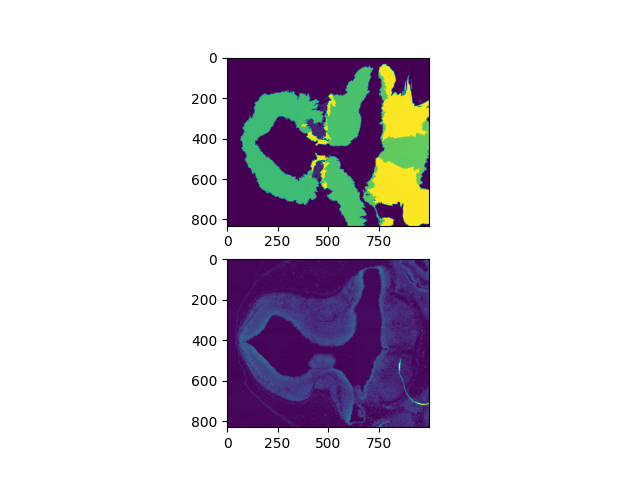

In [25]:
fig,ax = plt.subplots(2,1)
ax[0].imshow(AphiL%10001)
ax[1].imshow(J[0])

Now, we can explore our alignment and brain region annotations! 

We can visualize the MERFISH slice overlayed with the matched section in the Allen Brain Atlas.

<IPython.core.display.Javascript object>


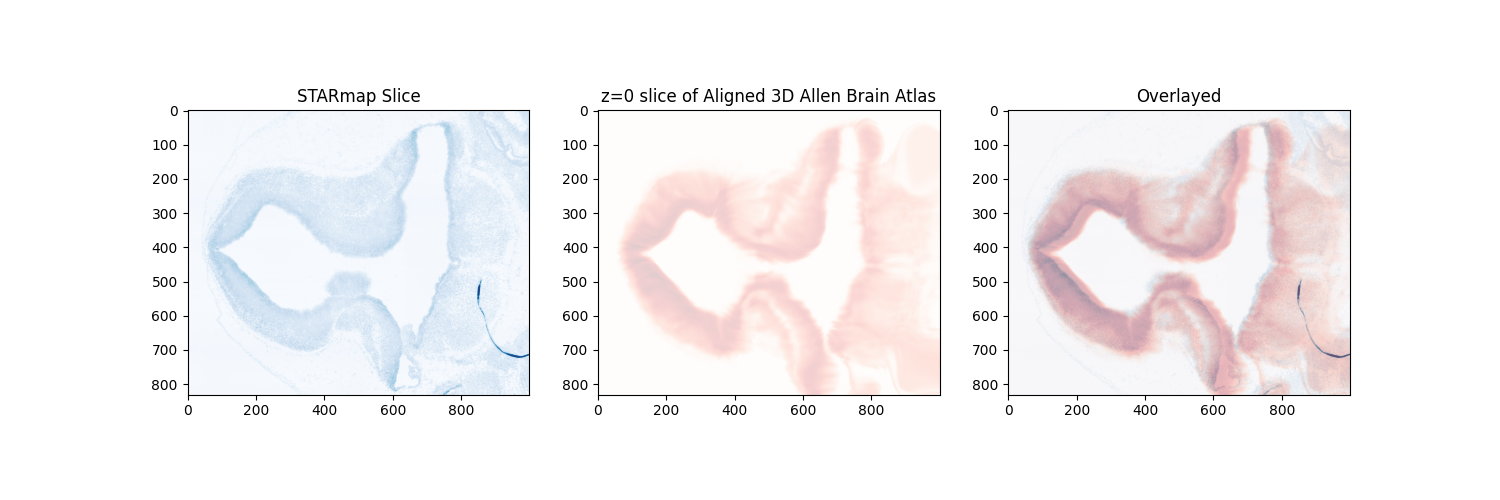

In [26]:
It = torch.tensor(I,device='cpu',dtype=torch.float64)
AI = STalign.interp3D(xI,It,Xs.permute(3,0,1,2),padding_mode="border")
Ishow_source = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
Jt = torch.tensor(J,device='cpu',dtype=torch.float64)
Ishow_target = Jt.permute(1,2,0).cpu()/torch.max(Jt).item()

import matplotlib as mpl
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax0 = ax[0].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax[0].set_title('STARmap Slice')
ax1 = ax[1].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.2)
ax[1].set_title('z=0 slice of Aligned 3D Allen Brain Atlas')
ax2 = ax[2].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax2 = ax[2].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.3)
ax[2].set_title('Overlayed')

plt.show()